In [23]:
# Instala as bibliotecas necessárias
!pip install yfinance pandas numpy statsmodels matplotlib seaborn

## Variáveis-chave

Defina aqui as variáveis essenciais para o valuation, como:

*   `ticker`: o código da ação a ser avaliada (ex: "PETR4.SA")
*   `market`: o código do índice de mercado para o CAPM (ex: "^BVSP" para o IBOVESPA)
*   `rf`: taxa livre de risco (em decimal)
*   `mkt_ret`: retorno esperado do mercado (em decimal)
*   Outras variáveis relevantes para o modelo de valuation.

In [24]:
# ===============================#
#   Imports e parâmetros globais #
# ===============================#

import yfinance as yf      # Para baixar dados de mercado
import pandas as pd        # Para manipulação de dados (DataFrames)
import numpy as np         # Para operações numéricas (cálculo de Beta)
import statsmodels.api as sm # Para modelos estatísticos (regressão OLS)
import matplotlib.pyplot as plt # Para visualização de dados (gráficos)
plt.rcParams["figure.dpi"] = 110  # Configura resolução para gráficos mais nítidos

# ---- Identificação dos ativos ----
ticker      = "PETR4.SA"   # Código da ação a ser avaliada (ex: "PETR4.SA")
market_idx  = "^BVSP"      # Código do índice de mercado para o CAPM (ex: "^BVSP" para o IBOVESPA)

# ---- Premissas macroeconômicas ----
risk_free   = 0.10   # Taxa livre de risco (em decimal) (ex.: SELIC a.a.)
market_ret  = 0.16   # Retorno esperado do mercado (em decimal)
tax_rate    = 0.34   # Alíquota de IR/CS sobre lucro (em decimal)

# ---- Estrutura de capital (place-holders; ajuste depois) ----
# Esses valores são placeholders e devem ser ajustados com dados reais da empresa
debt_total  = 4_000_000_000   # Dívida bruta total da empresa
equity_mkt  = 6_000_000_000   # Valor de mercado do patrimônio (Nº de ações * Preço da ação)
cost_debt   = 0.12            # Custo pré-imposto da dívida (em decimal)

# ---- Premissas de projeção de fluxo de caixa ----
fcf_base    = 1_000_000_000   # FCFF (Fluxo de Caixa Livre para a Firma) do ano-base
g_growth    = 0.05            # Taxa de crescimento anual do FCFF durante o horizonte explícito (ex: anos 1-5) (em decimal)
g_terminal  = 0.03            # Taxa de crescimento perpétuo do FCFF após o horizonte explícito (em decimal)
years_proj  = 5               # Horizonte explícito de projeção em anos

In [25]:
# ====================#
#   CAPM e Cálculo de Ke #
# ====================#

# Baixar dados históricos de preço para o ticker e o índice de mercado
# start="2019-01-01" define o início do período de análise para o cálculo do Beta
prices  = yf.download([ticker, market_idx], start="2019-01-01")

# Calcular os retornos diários percentuais e remover quaisquer linhas com valores ausentes (NaN)
# Acessamos os preços de fechamento ('Close') para cada ticker, já que o retorno baixado é MultiIndex
ret     = prices['Close'].pct_change().dropna()

# Preparar os dados para a regressão OLS (Ordinary Least Squares)
# 'y' é a variável dependente (retornos do ticker da ação)
y = ret[ticker]
# 'X' é a variável independente (retornos do índice de mercado), com a adição de uma constante para o intercepto
X = sm.add_constant(ret[market_idx])

# Executar a regressão OLS
model = sm.OLS(y, X).fit()

# Extrair o coeficiente Beta do modelo (a sensibilidade do retorno do ticker ao retorno do mercado)
beta = model.params[market_idx]   # β estimado

# Calcular o Custo de Capital Próprio (Ke) usando o modelo CAPM
# Fórmula: Ke = Taxa Livre de Risco + Beta * (Retorno Esperado do Mercado - Taxa Livre de Risco)
ke = risk_free + beta * (market_ret - risk_free)

# Exibir os resultados calculados
print(f"Beta ({ticker} vs {market_idx}): {beta:.4f}")
print(f"Custo de Capital Próprio (Ke): {ke:.4f}")

/tmp/ipython-input-25-3578717858.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices  = yf.download([ticker, market_idx], start="2019-01-01")
[*********************100%***********************]  2 of 2 completed


Beta (PETR4.SA vs ^BVSP): 1.2342
Custo de Capital Próprio (Ke): 0.1740


In [26]:
# =====================#
#   Cálculo do WACC    #
# =====================#

# Custo da dívida pós-imposto: Custo da Dívida * (1 - Alíquota de Imposto)
cost_debt_after_tax = cost_debt * (1 - tax_rate)

# Valor total da empresa (Enterprise Value): Dívida Total + Valor de Mercado do Patrimônio
total_value = debt_total + equity_mkt

# Peso da dívida na estrutura de capital: Dívida Total / Valor Total da Empresa
weight_debt = debt_total / total_value

# Peso do patrimônio na estrutura de capital: Valor de Mercado do Patrimônio / Valor Total da Empresa
weight_equity = equity_mkt / total_value

# Cálculo do WACC (Custo Médio Ponderado de Capital)
# Fórmula: (Peso do Patrimônio * Ke) + (Peso da Dívida * Custo da Dívida Pós-Imposto)
wacc = (weight_equity * ke) + (weight_debt * cost_debt_after_tax)

print(f"Custo da Dívida Pós-Imposto: {cost_debt_after_tax:.4f}")
print(f"Peso da Dívida: {weight_debt:.4f}")
print(f"Peso do Patrimônio: {weight_equity:.4f}")
print(f"Custo Médio Ponderado de Capital (WACC): {wacc:.4f}")

Custo da Dívida Pós-Imposto: 0.0792
Peso da Dívida: 0.4000
Peso do Patrimônio: 0.6000
Custo Médio Ponderado de Capital (WACC): 0.1361


In [27]:
# ==============================#
#   Projeção de FCFF e Valor Terminal #
# ==============================#

# Projetar FCFF para o horizonte explícito
fcfs_projetados = [fcf_base * (1 + g_growth)**i for i in range(1, years_proj + 1)]

# Calcular o Valor Terminal usando o Modelo de Crescimento de Gordon
# Assumindo que o primeiro fluxo de caixa no período terminal é fcf_projetados[-1] * (1 + g_terminal)
# É crucial garantir que WACC > g_terminal para o modelo ser válido.
if wacc <= g_terminal:
    valor_terminal = float('inf') # Ou outra forma de indicar que o modelo não é aplicável
    print("Atenção: WACC <= Taxa de Crescimento Terminal. O Modelo de Gordon não é aplicável.")
else:
    valor_terminal = (fcfs_projetados[-1] * (1 + g_terminal)) / (wacc - g_terminal)


print(f"Fluxos de Caixa Projetados ({years_proj} anos):")
for i, fcf in enumerate(fcfs_projetados):
    print(f"Ano {i+1}: {fcf:,.2f}")

print(f"\nValor Terminal (Modelo de Gordon): {valor_terminal:,.2f}")

Fluxos de Caixa Projetados (5 anos):
Ano 1: 1,050,000,000.00
Ano 2: 1,102,500,000.00
Ano 3: 1,157,625,000.00
Ano 4: 1,215,506,250.00
Ano 5: 1,276,281,562.50

Valor Terminal (Modelo de Gordon): 12,388,750,500.57


In [28]:
# =================================#
#   Valuation (DCF) e Valor do Patrimônio #
# =================================#

# Calcular o Valor Presente dos FCFFs projetados
pv_fcfs = sum(fcf / (1 + wacc)**i for i, fcf in enumerate(fcfs_projetados, 1))

# Calcular o Valor Presente do Valor Terminal
pv_valor_terminal = valor_terminal / (1 + wacc)**years_proj

# Calcular o Valor da Firma (Enterprise Value)
enterprise_value = pv_fcfs + pv_valor_terminal

# Calcular o Valor do Patrimônio (Equity Value)
# Assumindo Equity Value = Enterprise Value - Dívida Líquida (simplificado como Dívida Total neste caso)
equity_value = enterprise_value - debt_total

print(f"Valor Presente dos FCFFs Projetados: {pv_fcfs:,.2f}")
print(f"Valor Presente do Valor Terminal: {pv_valor_terminal:,.2f}")
print(f"\nValor da Firma (Enterprise Value): {enterprise_value:,.2f}")
print(f"Valor do Patrimônio (Equity Value): {equity_value:,.2f}")

Valor Presente dos FCFFs Projetados: 3,971,652,578.45
Valor Presente do Valor Terminal: 6,545,240,988.63

Valor da Firma (Enterprise Value): 10,516,893,567.08
Valor do Patrimônio (Equity Value): 6,516,893,567.08


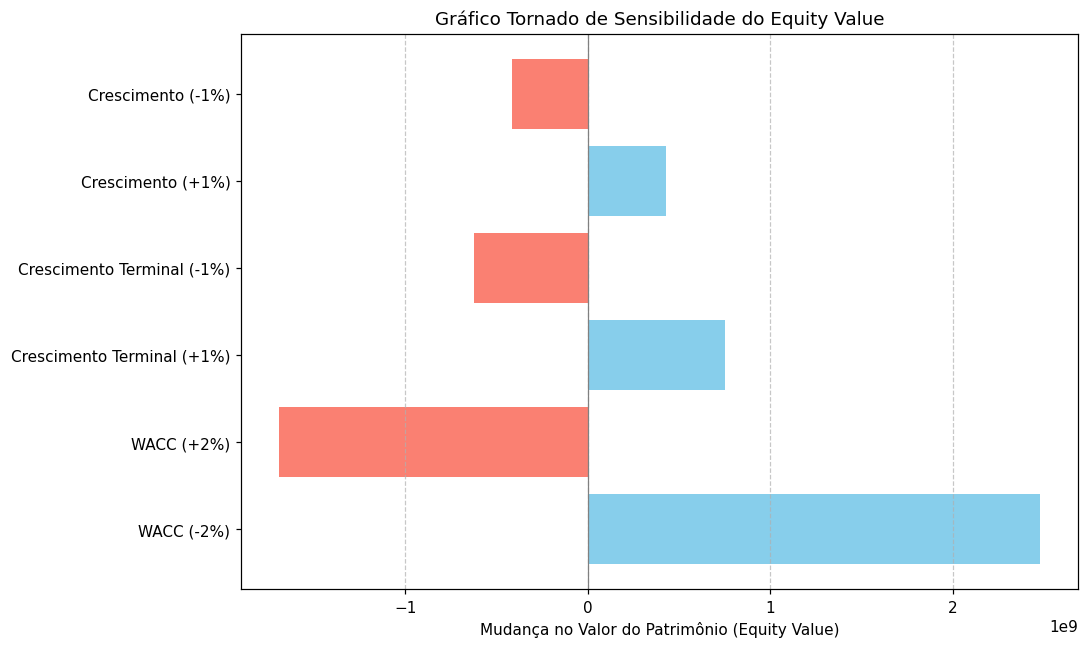


Resultados da Sensibilidade (Mudança no Equity Value):
WACC (+2%): -1,689,261,152.17
WACC (-2%): 2,476,196,491.29
Crescimento (+1%): 426,510,683.01
Crescimento (-1%): -412,034,758.15
Crescimento Terminal (+1%): 751,173,613.80
Crescimento Terminal (-1%): -621,783,591.63


In [29]:
# ========================================#
#   Gráfico Tornado de Sensibilidade     #
# ========================================#

# Definir variações para os parâmetros de sensibilidade
wacc_delta = 0.02
g_growth_delta = 0.01
g_terminal_delta = 0.01

# Armazenar os resultados da sensibilidade
sensibilidade = {}

# Função para calcular o Equity Value com base em parâmetros variados
def calcular_equity_value(wacc_sens, g_growth_sens, g_terminal_sens):
    """
    Calcula o Valor do Patrimônio (Equity Value) para um conjunto específico de premissas.

    Args:
        wacc_sens (float): O WACC a ser usado no cálculo.
        g_growth_sens (float): A taxa de crescimento anual do FCFF no horizonte explícito.
        g_terminal_sens (float): A taxa de crescimento perpétuo do FCFF.

    Returns:
        float: O Valor do Patrimônio calculado.
    """
    # Projetar FCFF com as premissas de sensibilidade
    fcfs_sens = [fcf_base * (1 + g_growth_sens)**i for i in range(1, years_proj + 1)]

    # Calcular o Valor Terminal com as premissas de sensibilidade
    # Evita divisão por zero ou valores negativos no denominador
    if wacc_sens <= g_terminal_sens:
        valor_terminal_sens = float('inf') if (fcfs_sens[-1] * (1 + g_terminal_sens)) > 0 else float('-inf')
    else:
        valor_terminal_sens = (fcfs_sens[-1] * (1 + g_terminal_sens)) / (wacc_sens - g_terminal_sens)


    # Calcular o Valor Presente dos FCFFs projetados com o WACC de sensibilidade
    pv_fcfs_sens = sum(fcf / (1 + wacc_sens)**i for i, fcf in enumerate(fcfs_sens, 1))

    # Calcular o Valor Presente do Valor Terminal com o WACC de sensibilidade
    pv_valor_terminal_sens = valor_terminal_sens / (1 + wacc_sens)**years_proj

    # Calcular o Valor da Firma
    enterprise_value_sens = pv_fcfs_sens + pv_valor_terminal_sens

    # Calcular o Valor do Patrimônio
    equity_value_sens = enterprise_value_sens - debt_total
    return equity_value_sens

# Valor base do Equity Value para comparação
base_equity_value = equity_value

# --- Calcular a sensibilidade para cada parâmetro ---

# Sensibilidade ao WACC
sensibilidade['WACC (+2%)'] = calcular_equity_value(wacc + wacc_delta, g_growth, g_terminal) - base_equity_value
sensibilidade['WACC (-2%)'] = calcular_equity_value(wacc - wacc_delta, g_growth, g_terminal) - base_equity_value

# Sensibilidade ao Crescimento (g_growth) no horizonte explícito
sensibilidade['Crescimento (+1%)'] = calcular_equity_value(wacc, g_growth + g_growth_delta, g_terminal) - base_equity_value
sensibilidade['Crescimento (-1%)'] = calcular_equity_value(wacc, g_growth - g_growth_delta, g_terminal) - base_equity_value

# Sensibilidade ao Crescimento Terminal (g_terminal)
# É crucial garantir que WACC > g_terminal para o modelo de Gordon ser válido.
# A função calcular_equity_value já trata casos onde WACC <= g_terminal.
sensibilidade['Crescimento Terminal (+1%)'] = calcular_equity_value(wacc, g_growth, g_terminal + g_terminal_delta) - base_equity_value
sensibilidade['Crescimento Terminal (-1%)'] = calcular_equity_value(wacc, g_growth, g_terminal - g_terminal_delta) - base_equity_value


# Preparar dados para o gráfico
# Remove resultados que são NaN (ocorrem se WACC <= g_terminal)
sensibilidade_plot = {k: v for k, v in sensibilidade.items() if not np.isnan(v)}
labels = list(sensibilidade_plot.keys())
values = list(sensibilidade_plot.values())


# Ordenar os resultados por magnitude (para o formato tornado) de forma decrescente
sorted_indices = np.argsort(np.abs(values))[::-1]
sorted_labels = [labels[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

# Criar o gráfico de barras horizontais (Gráfico Tornado)
plt.figure(figsize=(10, 6))
# Define a cor das barras: azul para aumento, salmão para diminuição
colors = ['skyblue' if v > 0 else 'salmon' for v in sorted_values]
plt.barh(sorted_labels, sorted_values, color=colors)
plt.xlabel('Mudança no Valor do Patrimônio (Equity Value)')
plt.title('Gráfico Tornado de Sensibilidade do Equity Value')
plt.grid(axis='x', linestyle='--', alpha=0.7) # Adiciona grid para facilitar leitura
plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Adiciona linha vertical no zero

# Melhorar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

# Opcional: imprimir valores exatos da sensibilidade
print("\nResultados da Sensibilidade (Mudança no Equity Value):")
for label, value in sensibilidade_plot.items():
    print(f"{label}: {value:,.2f}")

## 1. Setup

## 2. CAPM e Cálculo de Ke

## 3. Cálculo do WACC

## 4. Projeção de FCFF e Valor Terminal

## 5. Valuation (DCF) e Valor do Patrimônio

## 6. Gráfico Tornado de Sensibilidade

# Modelo de Valuation de Empresa por Fluxo de Caixa Descontado (DCF)

Este notebook apresenta um modelo simplificado de Valuation de Empresa utilizando a metodologia de Fluxo de Caixa Descontado (DCF). O objetivo é fornecer um MVP (Minimum Viable Product) funcional e didático para estimar o valor de uma empresa, com foco na clareza do código e na replicabilidade no Google Colab.

O modelo segue as seguintes etapas:
1.  **Setup Inicial:** Instalação de bibliotecas e definição de parâmetros-chave.
2.  **Cálculo do Custo de Capital Próprio (Ke):** Utilizando o modelo CAPM e dados históricos de mercado.
3.  **Cálculo do Custo Médio Ponderado de Capital (WACC):** Determinando a taxa de desconto apropriada para os fluxos de caixa.
4.  **Projeção de Fluxo de Caixa Livre para a Firma (FCFF) e Valor Terminal:** Estimando os fluxos futuros de caixa e o valor da empresa ao final do horizonte explícito.
5.  **Valuation (DCF):** Descontando os fluxos projetados e o valor terminal para obter o Valor da Firma e o Valor do Patrimônio.
6.  **Análise de Sensibilidade:** Visualizando o impacto da variação das premissas no Valor do Patrimônio através de um Gráfico Tornado.

---

## 1. Setup

Esta seção configura o ambiente necessário e define as premissas iniciais para o modelo de valuation. É aqui que você pode ajustar o ticker da empresa, o índice de mercado, taxas macroeconômicas e premissas financeiras da empresa.

## 2. CAPM e Cálculo de Ke

Esta seção calcula o Custo de Capital Próprio (Ke) utilizando o modelo CAPM (Capital Asset Pricing Model). O CAPM estima o retorno esperado de um ativo com base em seu risco sistemático (Beta) em relação ao mercado, a taxa livre de risco e o prêmio de risco de mercado.

O Beta é calculado através de uma regressão linear (OLS) dos retornos históricos da ação contra os retornos históricos de um índice de mercado relevante.

## 3. Cálculo do WACC

O Custo Médio Ponderado de Capital (WACC - Weighted Average Cost of Capital) representa a taxa de retorno mínima que uma empresa deve gerar sobre seus ativos para satisfazer seus provedores de capital (acionistas e credores). Ele é usado como taxa de desconto para trazer os fluxos de caixa futuros a valor presente no modelo DCF.

O WACC é calculado ponderando o custo do capital próprio (Ke) e o custo da dívida pós-impostos pelas suas respectivas participações na estrutura de capital da empresa.

## 4. Projeção de FCFF e Valor Terminal

Nesta etapa, projetamos os Fluxos de Caixa Livres para a Firma (FCFF) para um horizonte explícito de anos. O FCFF representa o caixa disponível para todos os provedores de capital da empresa após todas as despesas operacionais, impostos e investimentos em capital de giro e ativos fixos.

Além da projeção explícita, calculamos o Valor Terminal, que representa o valor de todos os fluxos de caixa que a empresa gerará após o horizonte explícito. O modelo de Gordon é frequentemente usado para este cálculo, assumindo uma taxa de crescimento perpétuo constante.

## 5. Valuation (DCF) e Valor do Patrimônio

A etapa final do modelo DCF é calcular o Valor da Firma (Enterprise Value) e o Valor do Patrimônio (Equity Value). O Valor da Firma é obtido descontando os FCFFs projetados e o Valor Terminal de volta ao presente utilizando o WACC como taxa de desconto.

O Valor do Patrimônio é então calculado subtraindo a dívida líquida (ou dívida total, em uma simplificação) do Valor da Firma. Este valor representa a riqueza disponível para os acionistas da empresa.

## 6. Gráfico Tornado de Sensibilidade

A análise de sensibilidade é crucial em modelos de valuation para entender como o Valor do Patrimônio (Equity Value) é afetado por mudanças nas premissas-chave do modelo (como WACC, taxa de crescimento e taxa de crescimento terminal).

O Gráfico Tornado visualiza o impacto de variar cada premissa individualmente, mostrando quais premissas têm o maior efeito sobre o resultado final do valuation. Isso ajuda a identificar os principais direcionadores de valor e os riscos associados.